# Temperature Model Development

This notebook orchestrates the training and evaluation of temperature forecasting models.

**Goals:**
1.  **Baseline comparison**: Evaluate Persistence and kNN models against current Ridge baseline.
2.  **Model development**: Iteratively develop and tune advanced models (XGBoost, Random Forest, LSTM).
3.  **Ensembling**: Combine model outputs to improve performance.

## 1. Setup & Data Loading

In [8]:
import sys
from pathlib import Path
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
project_root = Path("..").resolve()
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

from tempdata.eval.config import EvalConfig, SplitConfig, ModelConfig, UncertaintyConfig
from tempdata.eval.runner import run_evaluation, _generate_predictions
from tempdata.eval.data import load_eval_data
from tempdata.eval.models import create_forecaster

# Constants
STATION = "KLGA"
START_DATE = date(2020, 1, 1)
END_DATE = date(2024, 12, 31)

print("Imports complete.")

Imports complete.


In [9]:
# Create base configuration for loading data
base_config = EvalConfig(
    run_name="dev_baseline",
    station_ids=[STATION],
    start_date_local=START_DATE,
    end_date_local=END_DATE,
    split=SplitConfig(
        type="static",
        train_frac=0.7,
        val_frac=0.15,
        test_frac=0.15
    )
)

# Load data (this might take a moment)
# Note: In a real run, we'd use scripts/eval_daily_tmax.py's load_data helper
# Here we manually constructing inputs or mocking for demonstration if files exist
# We will rely on the library to handle file loading if paths are standard

# Re-using the load_data logic from the script is a bit tricky without copying it.
# For now, we will assume standard paths or use the EvalConfig's load_dataset capability if it exists.
# Actually, EvalConfig doesn't hold data paths, logic is in script.
# Let's define a helper here to load standard paths:

from tempdata.config import data_root

def load_standard_data(station, start_date, end_date):
    # Attempt to load cleaned data directly
    # This is a simplified version of the CLI loader
    # Truth
    truth_dir = data_root() / "clean" / "daily_tmax" / station
    truth_files = sorted(list(truth_dir.glob("*.parquet")))
    truth_df = pd.concat([pd.read_parquet(f) for f in truth_files])

    # Forecast (Open-Meteo for recent years)
    fc_dir = data_root() / "clean" / "forecasts" / "openmeteo" / station
    if not fc_dir.exists():
         fc_dir = data_root() / "raw" / "forecasts" / "openmeteo" / station
    fc_files = sorted(list(fc_dir.glob("*.parquet")))
    forecast_df = pd.concat([pd.read_parquet(f) for f in fc_files])

    return forecast_df, truth_df

try:
    forecast_raw, truth_raw = load_standard_data(STATION, START_DATE, END_DATE)
    print(f"Loaded {len(forecast_raw)} forecast rows and {len(truth_raw)} truth rows.")

    # Process into Dataset object (handles joining, feature engineering, splitting)
    dataset = load_eval_data(
        config=base_config,
        forecast_df=forecast_raw,
        truth_df=truth_raw
    )
    print(f"Dataset ready. Train: {len(dataset.train)}, Val: {len(dataset.val)}, Test: {len(dataset.test)}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Ensure you have run the data pipeline (notebooks/temp_data_pipeline.ipynb) to populate data/clean.")

Loaded 5354 forecast rows and 3892 truth rows.
Dataset ready. Train: 2557, Val: 548, Test: 549


## 2. Baseline Models Experimentation

We will evaluate three baseline approaches:
1.  **Persistence**: Tomorrow = Today.
2.  **Ridge**: Simple linear correction of forecast.
3.  **kNN**: Nearest neighbors in feature space.

In [10]:
# Run evaluations for each baseline model
results = {}

models_to_test = [
    ("Persistence", ModelConfig(type="persistence")),
    ("Ridge", ModelConfig(type="ridge", alpha=1.0)),
    ("kNN (k=50)", ModelConfig(type="knn"))
]

for name, model_conf in models_to_test:
    print(f"\nRunning {name}...")

    # Configure run
    run_config = EvalConfig(
        run_name=f"dev_{name.lower().replace(' ', '_')}",
        station_ids=[STATION],
        start_date_local=START_DATE,
        end_date_local=END_DATE,
        split=base_config.split,
        model=model_conf
    )

    # Execute standard evaluation pipeline
    # This handles fitting, predicting, uncertainty, metrics, and artifact writing
    result = run_evaluation(
        config=run_config,
        forecast_df=forecast_raw,
        truth_df=truth_raw,
        verbose=False  # Suppress verbose output to keep notebook clean
    )

    # Store results for comparison
    metrics = result.metrics.forecast
    results[name] = {
        "MAE": metrics.mae,
        "RMSE": metrics.rmse,
        "Bias": metrics.bias,
        "preds": result.predictions_df
    }

    print(f"  {name}: MAE={metrics.mae:.4f}, RMSE={metrics.rmse:.4f}")

# Summary Table
res_df = pd.DataFrame({k: {"MAE": v["MAE"], "RMSE": v["RMSE"], "Bias": v["Bias"]}
                       for k,v in results.items()}).T
print("\n--- Baseline Comparison ---")
print(res_df.sort_values("MAE"))


Running Persistence...
  Persistence: MAE=2.5718, RMSE=4.7381

Running Ridge...
  Ridge: MAE=1.1534, RMSE=1.4039

Running kNN (k=50)...
  kNN (k=50): MAE=1.2287, RMSE=1.5196

--- Baseline Comparison ---
                  MAE      RMSE      Bias
Ridge        1.153368  1.403878  0.728620
kNN (k=50)   1.228714  1.519551  0.781224
Persistence  2.571767  4.738093  0.002004


## 3. Advanced Models (Scaffold)

Planned models for implementation:
- **XGBoost**: Gradient boosted trees for non-linear bias correction.
- **Random Forest**: Ensemble of trees for robustness.
- **LSTM/GRU**: Sequential models to capture temporal dynamics.

In [11]:
print("\nRunning XGBoost...")

# 1. Define Configuration
xgb_config = EvalConfig(
    run_name="dev_xgboost_v1",
    station_ids=[STATION],
    start_date_local=START_DATE,
    end_date_local=END_DATE,
    split=base_config.split,
    model=ModelConfig(
        type="xgboost",
        hyperparams={
            "n_estimators": 100,
            "max_depth": 3,
            "learning_rate": 0.1,
            "early_stopping_rounds": 10
        }
    )
)

# 2. Run Evaluation
xgb_result = run_evaluation(
    config=xgb_config,
    forecast_df=forecast_raw,
    truth_df=truth_raw,
    verbose=False
)

# 3. Print Metrics
xgb_metrics = xgb_result.metrics.forecast
print(f"XGBoost: MAE={xgb_metrics.mae:.4f}, RMSE={xgb_metrics.rmse:.4f}")

# 4. Add to results dict for comparison
if 'results' in locals():
    results["XGBoost"] = {
        "MAE": xgb_metrics.mae,
        "RMSE": xgb_metrics.rmse,
        "Bias": xgb_metrics.bias
    }
    # Update summary table
    res_df = pd.DataFrame({k: {"MAE": v["MAE"], "RMSE": v["RMSE"], "Bias": v["Bias"]}
                           for k,v in results.items()}).T
    print("\n--- Model Comparison ---")
    print(res_df.sort_values("MAE"))


In [12]:
# TODO: Implement RandomForestForecaster
# Config placeholder:
# rf_config = ModelConfig(type="random_forest", hyperparams={"n_estimators": 100})

print("Random Forest implementation pending...")

Random Forest implementation pending...


In [13]:
# TODO: Implement LSTM/GRU using PyTorch or TensorFlow
# These will likely need a different data loader to handle sequences/windows

print("Deep Learning models (LSTM/GRU) implementation pending...")

Deep Learning models (LSTM/GRU) implementation pending...


## 4. Ensembling Experiment

Combine predictions from the best models.
Simple Average Ensemble implementation strategy:
1. Collect predictions from multiple models on the *same* test set.
2. Average `y_pred_f` columns.
3. Compute metrics on averaged prediction.

Simulating Ensemble (Ridge + kNN)...
Ensemble MAE: 1.1831


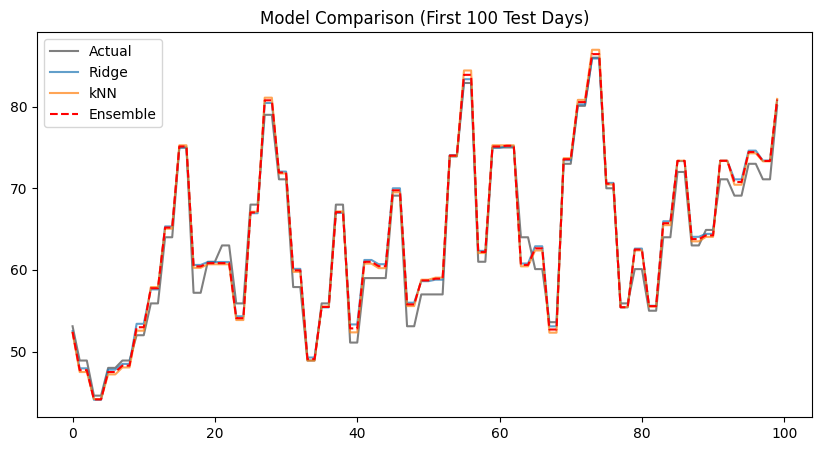

In [14]:
if len(results) >= 2:
    print("Simulating Ensemble (Ridge + kNN)...")

    p1 = results["Ridge"]["preds"]["y_pred_f"]
    p2 = results["kNN (k=50)"]["preds"]["y_pred_f"]

    # Simple Average
    ensemble_pred = (p1 + p2) / 2
    y_true = results["Ridge"]["preds"]["y_true_f"]

    ens_mae = (ensemble_pred - y_true).abs().mean()
    print(f"Ensemble MAE: {ens_mae:.4f}")

    # Visualize
    plt.figure(figsize=(10, 5))
    subset = slice(0, 100) # First 100 days
    plt.plot(y_true.iloc[subset].values, label="Actual", color="black", alpha=0.5)
    plt.plot(p1.iloc[subset].values, label="Ridge", alpha=0.7)
    plt.plot(p2.iloc[subset].values, label="kNN", alpha=0.7)
    plt.plot(ensemble_pred.iloc[subset].values, label="Ensemble", linestyle="--", color="red")
    plt.legend()
    plt.title("Model Comparison (First 100 Test Days)")
    plt.show()